In [ ]:
# for real data
# create dataset of number sequences
# let's assume that we have a vocabulary size of 1000 words
# let's assume that 0 is the EOS token, and 1 is the SOS token, and 2 is PAD

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import torch.nn.functional as F
from models.copynet_debug import CopyEncoder, CopyDecoder
from models.functions import numpy_to_var, toData, to_np, to_var, visualize, decoder_initial, update_logger
import time
import sys
import math
torch.manual_seed(1000)

# Hyperparameters
embed_size = 150
hidden_size = 300
num_layers = 1
bin_size = 10
num_epochs = 40
prev_end=0
batch_size = 100
lr = 0.001
vocab_size = 100
weight_decay = 0.99
use_saved = True # whether to train from a previous model
continue_from = 70
step = 0 # number of steps taken

# input and output directories
version = 'v6'
vocab_size = 1000
data_dir = 'data/copynet_data_%s.txt' %(version)
save_dir = 'results/copynet_data_%s.csv' %(version)


# get training and test data
with open(data_dir) as f:
    lines = f.readlines()
import random
half = int(len(lines)/2)
train = lines
random.shuffle(train)
test = train[:20]
train = train[20:]

# get number of batches
num_samples = len(train)
num_batches = int(num_samples/batch_size)


################ load copynet model #####################
if use_saved:
    # if using from previous data
    encoder_dir = 'models/encoder_%s_%s.pckl' % (version,continue_from)
    decoder_dir = 'models/decoder_%s_%s.pckl' % (version,continue_from)
    encoder = torch.load(f=encoder_dir)
    decoder = torch.load(f=decoder_dir)
else:
    encoder = CopyEncoder(vocab_size, embed_size, hidden_size)
    decoder = CopyDecoder(vocab_size, embed_size, hidden_size)
    continue_from = 0
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

################################# training ##################################

# set loss
criterion = nn.NLLLoss()

start = time.time()
for epoch in range(num_epochs):
    print("==================================================")
    print("Epoch ",epoch+1)
    opt_e = optim.Adam(params=encoder.parameters(), lr=lr)
    opt_d = optim.Adam(params=decoder.parameters(), lr=lr)
    lr= lr * weight_decay # weight decay
    # shuffle data
    random.shuffle(train)
    samples_read = 0
    while(samples_read<len(train)):
        # initialize gradient buffers
        opt_e.zero_grad()
        opt_d.zero_grad()

        # obtain batch outputs
        batch = train[samples_read:min(samples_read+batch_size,len(train))]
        input_out, output_out, in_len, out_len = toData(batch)
        samples_read+=len(batch)

        # mask input to remove padding
        input_mask = np.array(input_out>0, dtype=int)

        # input and output in Variable form
        x = numpy_to_var(input_out)
        y = numpy_to_var(output_out)

        # apply to encoder
        encoded, _ = encoder(x)

        # get initial input of decoder
        decoder_in, s, w = decoder_initial(x.size(0))

        # out_list to store outputs
        out_list=[]
        for j in range(y.size(1)): # for all sequences
            """
            decoder_in (Variable): [b]
            encoded (Variable): [b x seq x hid]
            input_out (np.array): [b x seq]
            s (Variable): [b x hid]
            """
            # 1st state
            if j==0:
                out, s, w = decoder(input_idx=decoder_in, encoded=encoded,
                                encoded_idx=input_out, prev_state=s,
                                weighted=w, order=j)
            # remaining states
            else:
                tmp_out, s, w = decoder(input_idx=decoder_in, encoded=encoded,
                                encoded_idx=input_out, prev_state=s,
                                weighted=w, order=j)
                out = torch.cat([out,tmp_out],dim=1)

            # for debugging: stop if nan
            if math.isnan(w[-1][0][0].data[0]):
                sys.exit()
            # select next input

            if epoch % 2 ==13:
                decoder_in = out[:,-1].max(1)[1].squeeze() # train with sequence outputs
            else:
                decoder_in = y[:,j] # train with ground truth
            out_list.append(out[:,-1].max(1)[1].squeeze().cpu().data.numpy())

        # print(torch.stack(decoder.prob_c_to_g,1))
        target = pack_padded_sequence(y,out_len.tolist(), batch_first=True)[0]
        pad_out = pack_padded_sequence(out,out_len.tolist(), batch_first=True)[0]
        # include log computation as we are using log-softmax and NLL
        pad_out = torch.log(pad_out)
        loss = criterion(pad_out, target)
        loss.backward()
        # if samples_read%500==0:
        print("[%d/%d] Loss: %1.4f"%(samples_read,len(train),loss.data[0]))
        opt_e.step()
        opt_d.step()
        step += 1
        info = {
            'loss': loss.data[0]
        }
    # print("Loss: ",loss.data[0])
    elapsed = time.time()
    print("Elapsed time for epoch: ",elapsed-start)
    start = time.time()

    ################################# validation ##################################
    if epoch % 10==0:
        print("Printing results")
        input_out, output_out, in_len, out_len = toData(test)
        input_mask = np.array(input_out>0, dtype=int)
        x = numpy_to_var(input_out)
        y = numpy_to_var(output_out)
        if epoch==0:
            with open(save_dir,'a') as f:
                x_input = x.cpu().data.numpy().transpose()
                y_input = y.cpu().data.numpy().transpose()
                m = max(x_input.shape[0],y_input.shape[0])
                out_ = np.zeros([m,x_input.shape[1]*2])
                out_[:x_input.shape[0],x_input.shape[1]:]=x_input
                out_[:y_input.shape[0],:y_input.shape[1]]=y_input
                out = []
                for line in out_:
                    tmp = ','.join([str(x_) for x_ in line])
                    out.append(tmp)
                f.write('\n'.join(out)+'\n')
        encoded, _ = encoder(x)
        decoder_in, s, w = decoder_initial(x.size(0))
        out_list=[]
        for j in range(y.size(1)): # for all sequences
            if j==0:
                out, s, w = decoder(input_idx=decoder_in, encoded=encoded,
                                encoded_idx=input_out, prev_state=s,
                                weighted=w, order=j)
            else:
                tmp_out, s, w = decoder(input_idx=decoder_in, encoded=encoded,
                                encoded_idx=input_out, prev_state=s,
                                weighted=w, order=j)
                out = torch.cat([out,tmp_out],dim=1)
            decoder_in = out[:,-1].max(1)[1].squeeze() # train with sequence outputs
            out_list.append(out[:,-1].max(1)[1].squeeze().cpu().data.numpy())
        out = np.array(out_list)
        iden = np.array(out==y_input,dtype=int)
        with open(save_dir,'a') as f:
            out = np.hstack(tup=(out,iden))
            f.write('\n')
            for line in out:
                f.write(','.join([str(y_) for y_ in line])+'\n')
        torch.save(f='models/encoder_%s_%s.pckl' % (version,str(epoch+continue_from)),obj=encoder)
        torch.save(f='models/decoder_%s_%s.pckl' % (version,str(epoch+continue_from)),obj=decoder)


Epoch  1
[100/980] Loss: 0.3453
[200/980] Loss: 0.3516


KeyboardInterrupt: 

In [3]:
################################# validation ##################################
print("Printing results")
input_out, output_out, in_len, out_len = toData(test[:10])
input_mask = np.array(input_out>0, dtype=int)
x = numpy_to_var(input_out)
y = numpy_to_var(output_out)
encoded, _ = encoder(x)
decoder_in, s, w = decoder_initial(x.size(0))
out_list=[]
for j in range(y.size(1)): # for all sequences
    if j==0:
        out, s, w = decoder(input_idx=decoder_in, encoded=encoded,
                        encoded_idx=input_out, prev_state=s, 
                        weighted=w, order=j)
    else:
        tmp_out, s, w = decoder(input_idx=decoder_in, encoded=encoded,
                        encoded_idx=input_out, prev_state=s, 
                        weighted=w, order=j)
        out = torch.cat([out,tmp_out],dim=1)
    decoder_in = y[:,j] # train with ground truth
#     decoder_in = out[:,-1].max(1)[1].squeeze() # train with sequence outputs
    out_list.append(out[:,-1].max(1)[1].squeeze().cpu().data.numpy())
# with open(save_dir,'a') as f:
#     out = np.hstack(tup=(out,iden))
#     f.write('\n')
#     for line in out:
#         f.write(','.join([str(y_) for y_ in line])+'\n')

Printing results


In [4]:
%matplotlib inline

In [11]:
# debug
# get a sample input, ground truth, output
idx = 0
print("input: ",x[idx].cpu().data.numpy())
print("truth: ",y[idx].cpu().data.numpy())
O = torch.cat(decoder.O,1)
print("output: ",O[idx].max(1)[1].cpu().numpy().squeeze())
A = torch.stack(decoder.A,1)
A2 = torch.stack(decoder.A2,1)
P = torch.stack(decoder.P,1)
I = torch.stack(decoder.I,1)
E = torch.stack(decoder.E,1)
S = torch.stack(decoder.S,1)
W = torch.cat(decoder.W,1)
Y = torch.stack(decoder.Y,1)
scores = torch.stack(decoder.scores,1)
sc = torch.stack(decoder.sc,1)
pcg = torch.stack(decoder.prob_c_to_g,1)
pc = P[:,:,1000:]
pg = P[:,:,:1000]

input:  [502 840 679 776 209 707 471 490 267   1]
truth:  [467 864 939 103 840 679 776 209 863 938   1]
output:  [467 864 939 103 840 840 776 776 863 938   1]


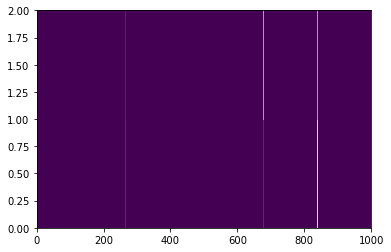

In [14]:
visualize(Variable(O[idx,4:6,:]))